# Making Predictions - Preparation Work

We trained the model previously to learn the features of a car, and identify what make/model it is. Now, we can feed in new images to see it works properly

Import all neccessary libraries

In [16]:
from __future__ import division
import cv2
import numpy as np
import sys
import pickle
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras_frcnn import roi_helpers
from matplotlib import pyplot as plt
import os
import pandas as pd
import webcolors
import random
from collections import Counter

Configure recursion limit

In [17]:
sys.setrecursionlimit(40000)

Set working directories

In [18]:
current_working_directory = os.getcwd()
parent_working_directory = os.path.dirname(current_working_directory) # go up one directory
car_metadata_csv = os.path.join(parent_working_directory, "1-Read_From_MatLab_To_CSV", "cars_meta.csv")

Set image location

In [19]:
img_location = os.path.join(current_working_directory, "00019.jpg")
img = cv2.imread(img_location)

Load car metadata from csv file

In [20]:
car_metadata = pd.read_csv(car_metadata_csv)
car_make_model = car_metadata["class_name"]

Import configuration file for data model

In [21]:
config_output_filename = "config.pickle"

with open(config_output_filename, 'rb') as f_in:
    C = pickle.load(f_in)

if C.network == 'resnet50':
    import keras_frcnn.resnet as nn
elif C.network == 'vgg':
    import keras_frcnn.vgg as nn

Turn off any data augmentation

In [22]:
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

Formats the image size, based on configuration

In [23]:
def format_img_size(img, C):
    """ formats the image size based on config """
    img_min_side = float(C.im_size)
    (height,width,_) = img.shape

    if width <= height:
        ratio = img_min_side/width
        new_height = int(ratio * height)
        new_width = int(img_min_side)
    else:
        ratio = img_min_side/height
        new_width = int(ratio * width)
        new_height = int(img_min_side)
    img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    return img, ratio	

Formats the image channel, based on configuration

In [24]:
def format_img_channels(img, C):
    """ formats the image channels based on config """
    img = img[:, :, (2, 1, 0)]
    img = img.astype(np.float32)
    img[:, :, 0] -= C.img_channel_mean[0]
    img[:, :, 1] -= C.img_channel_mean[1]
    img[:, :, 2] -= C.img_channel_mean[2]
    img /= C.img_scaling_factor
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, axis=0)
    return img

Formats an image for model prediction based on config

In [25]:
def format_img(img, C):
    """ formats an image for model prediction based on config """
    img, ratio = format_img_size(img, C)
    img = format_img_channels(img, C)
    return img, ratio

Transforms coordinates of bounding box to original size

In [26]:
# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):

    real_x1 = int(round(x1 // ratio))
    real_y1 = int(round(y1 // ratio))
    real_x2 = int(round(x2 // ratio))
    real_y2 = int(round(y2 // ratio))

    return (real_x1, real_y1, real_x2 ,real_y2)

Mapping of the labels

In [27]:
class_mapping = C.class_mapping

if 'bg' not in class_mapping:
    class_mapping['bg'] = len(class_mapping)

class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}
#C.num_rois = int(options.num_rois)

if C.network == 'resnet50':
    num_features = 1024
elif C.network == 'vgg':
    num_features = 512

if K.image_dim_ordering() == 'th':
    input_shape_img = (3, None, None)
    input_shape_features = (num_features, None, None)
else:
    input_shape_img = (None, None, 3)
    input_shape_features = (None, None, num_features)


img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

{0: '14', 1: '3', 2: '91', 3: '134', 4: '106', 5: '123', 6: '89', 7: '96', 8: '167', 9: '58', 10: '49', 11: '186', 12: '135', 13: '85', 14: '193', 15: '172', 16: '73', 17: '192', 18: '57', 19: '79', 20: '36', 21: '120', 22: '170', 23: '194', 24: '184', 25: '86', 26: '180', 27: '154', 28: '139', 29: '66', 30: '133', 31: '104', 32: '38', 33: '97', 34: '105', 35: '142', 36: '13', 37: '191', 38: '119', 39: '25', 40: '177', 41: '173', 42: '42', 43: '148', 44: '15', 45: '53', 46: '44', 47: '65', 48: '90', 49: '124', 50: '114', 51: '190', 52: '101', 53: '187', 54: '8', 55: '17', 56: '111', 57: '122', 58: '5', 59: '29', 60: '126', 61: '94', 62: '188', 63: '59', 64: '110', 65: '43', 66: '18', 67: '116', 68: '145', 69: '20', 70: '165', 71: '138', 72: '175', 73: '112', 74: '51', 75: '37', 76: '71', 77: '61', 78: '74', 79: '162', 80: '131', 81: '88', 82: '121', 83: '137', 84: '83', 85: '147', 86: '161', 87: '109', 88: '28', 89: '144', 90: '136', 91: '143', 92: '171', 93: '178', 94: '56', 95: '40',

In [28]:
# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = nn.nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = nn.rpn(shared_layers, num_anchors)

classifier = nn.classifier(feature_map_input, roi_input, C.num_rois, nb_classes=len(class_mapping), trainable=True)

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)

print('Loading weights from {}'.format(C.model_path))
model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

all_imgs = []
classes = {}
bbox_threshold = 0.8
visualise = True

Loading weights from ./model_frcnn.hdf5


# Colours

In [29]:
def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.css3_hex_to_names.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = webcolors.rgb_to_name(requested_colour)
        
    except ValueError:
        closest_name = closest_colour(requested_colour)
        
    return closest_name

def get_colour_from_img(photo):
    red_arr = []
    green_arr = []
    blue_arr = []
    
    # Gets resolution of image
    width = int(photo.shape[0])
    height = int(photo.shape[1])
    
    # Scan through all the entire picture for values of the 
    for w in range(width):
        for h in range(height):
            #  Pull out color space information
            all_colors = photo[w,h,:]
            
            # Individual Color space
            red = all_colors[2]
            green = all_colors[1]
            blue = all_colors[0]
            
            # Append to array
            red_arr.append(red)
            green_arr.append(green)
            blue_arr.append(blue)
    
    # Aggregate the data, and finds the average
    red_final = int(np.average(red_arr))
    green_final = int(np.average(green_arr))
    blue_final = int(np.average(blue_arr))
    
    # Concatenate new RGB data into array
    rgb_final = [red_final, green_final, blue_final]
    
    # Make use of https://stackoverflow.com/questions/9694165/convert-rgb-color-to-english-color-name-like-green-with-python
    # code to find closest color
    closest_name = get_colour_name(rgb_final)
    
    return closest_name

# Making Predictions - Actual

C:\Users\jerome\Anaconda3\envs\tf_gpu\lib\site-packages\numpy\lib\function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\jerome\Anaconda3\envs\tf_gpu\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Counter({'darkslategrey': 19, 'sienna': 17, 'brown': 9, 'darkolivegreen': 8, 'indianred': 7, 'saddlebrown': 6, 'dimgrey': 3, 'crimson': 1, 'gray': 1})


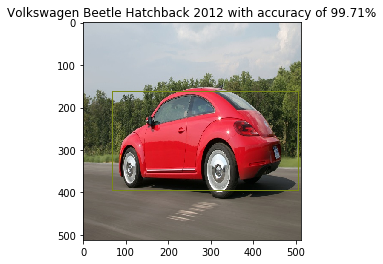

Counter({'sienna': 43, 'darkslategrey': 29, 'brown': 16, 'darkolivegreen': 13, 'indianred': 12, 'saddlebrown': 11, 'dimgrey': 9, 'crimson': 6, 'gray': 1})


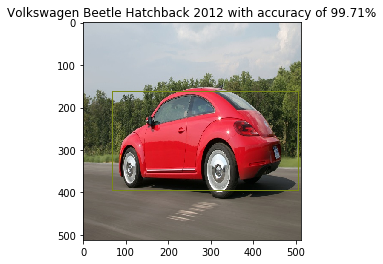

Counter({'sienna': 70, 'darkslategrey': 38, 'brown': 26, 'indianred': 21, 'darkolivegreen': 20, 'saddlebrown': 15, 'dimgrey': 14, 'crimson': 6, 'gray': 1, 'tomato': 1})


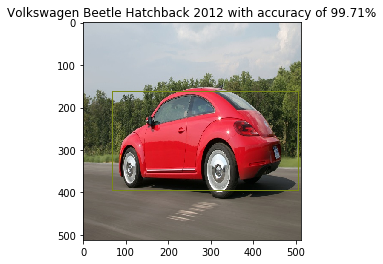

Counter({'sienna': 92, 'darkslategrey': 50, 'darkolivegreen': 30, 'brown': 30, 'indianred': 27, 'dimgrey': 21, 'saddlebrown': 18, 'crimson': 7, 'gray': 5, 'tomato': 1, 'darkgrey': 1})


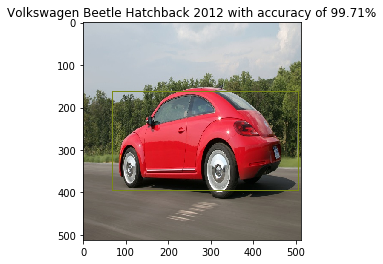

Counter({'sienna': 115, 'darkslategrey': 62, 'darkolivegreen': 41, 'brown': 35, 'indianred': 33, 'dimgrey': 28, 'saddlebrown': 26, 'crimson': 8, 'gray': 7, 'tomato': 1, 'darkgrey': 1, 'firebrick': 1})


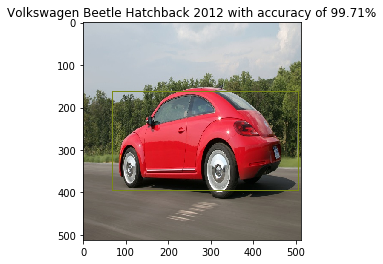

Counter({'sienna': 141, 'darkslategrey': 72, 'darkolivegreen': 49, 'brown': 46, 'indianred': 40, 'dimgrey': 33, 'saddlebrown': 30, 'crimson': 8, 'gray': 8, 'firebrick': 2, 'tomato': 1, 'darkgrey': 1, 'salmon': 1, 'black': 1})


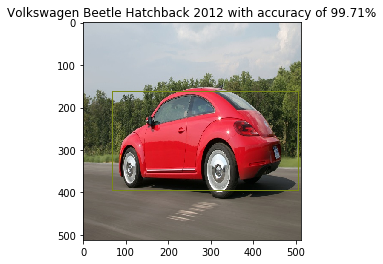

Counter({'sienna': 160, 'darkslategrey': 83, 'darkolivegreen': 63, 'brown': 55, 'indianred': 47, 'dimgrey': 39, 'saddlebrown': 37, 'crimson': 8, 'gray': 8, 'firebrick': 3, 'darkgrey': 2, 'tomato': 1, 'salmon': 1, 'black': 1})


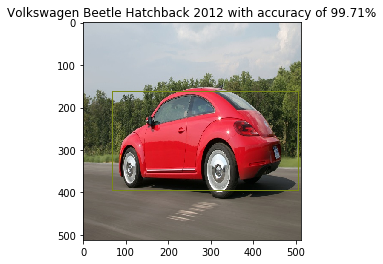

Counter({'sienna': 176, 'darkslategrey': 92, 'darkolivegreen': 71, 'brown': 68, 'indianred': 54, 'dimgrey': 47, 'saddlebrown': 43, 'gray': 12, 'crimson': 10, 'firebrick': 3, 'darkgrey': 2, 'tomato': 1, 'salmon': 1, 'black': 1, 'rosybrown': 1, 'olivedrab': 1})


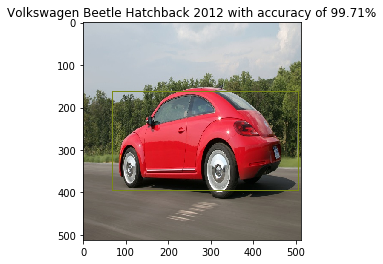

Counter({'sienna': 200, 'darkslategrey': 98, 'darkolivegreen': 84, 'brown': 76, 'indianred': 61, 'dimgrey': 55, 'saddlebrown': 46, 'gray': 13, 'crimson': 11, 'darkgrey': 3, 'firebrick': 3, 'tomato': 1, 'salmon': 1, 'black': 1, 'rosybrown': 1, 'olivedrab': 1})


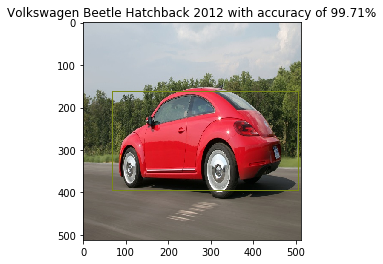

Counter({'sienna': 222, 'darkslategrey': 109, 'darkolivegreen': 88, 'brown': 79, 'indianred': 71, 'dimgrey': 60, 'saddlebrown': 51, 'gray': 16, 'crimson': 13, 'darkgrey': 3, 'firebrick': 3, 'tomato': 1, 'salmon': 1, 'black': 1, 'rosybrown': 1, 'olivedrab': 1, 'lightslategrey': 1})


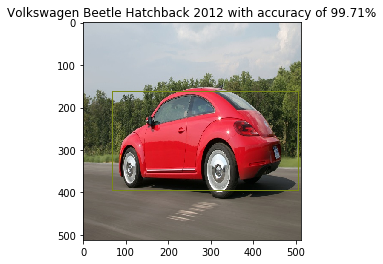

In [30]:
X, ratio = format_img(img, C)

if K.image_dim_ordering() == 'tf':
	X = np.transpose(X, (0, 2, 3, 1))

# get the feature maps and output from the RPN
[Y1, Y2, F] = model_rpn.predict(X)


R = roi_helpers.rpn_to_roi(Y1, Y2, C, K.image_dim_ordering(), overlap_thresh=0.7)

# convert from (x1,y1,x2,y2) to (x,y,w,h)
R[:, 2] -= R[:, 0]
R[:, 3] -= R[:, 1]

# apply the spatial pyramid pooling to the proposed regions
bboxes = {}
probs = {}
color_arr = []

# Main Program
for jk in range(R.shape[0]//C.num_rois + 1):
    ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
    if ROIs.shape[1] == 0:
        break

    if jk == R.shape[0]//C.num_rois:
        #pad R
        curr_shape = ROIs.shape
        target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
        ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
        ROIs_padded[:, :curr_shape[1], :] = ROIs
        ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
        ROIs = ROIs_padded

    [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

    for ii in range(P_cls.shape[1]):

        if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
            continue

        cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

        if cls_name not in bboxes:
            bboxes[cls_name] = []
            probs[cls_name] = []

        (x, y, w, h) = ROIs[0, ii, :]

        cls_num = np.argmax(P_cls[0, ii, :])
        try:
            (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
            tx /= C.classifier_regr_std[0]
            ty /= C.classifier_regr_std[1]
            tw /= C.classifier_regr_std[2]
            th /= C.classifier_regr_std[3]
            x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
        except:
            pass
        bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
        probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = roi_helpers.non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]

            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

            cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),2)
            
            textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
            all_dets.append((key,100*new_probs[jk]))
            predicted_accuracy = round(100*new_probs[jk],2)

            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
            textOrg = (real_x1, real_y1-0)
            
            image_region = img[real_y1:real_y2, real_x1:real_x2]
            
            for x in range(100):
                try:
                    x1_new = random.randint(0, image_region.shape[0])
                    y1_new = random.randint(0, image_region.shape[1])

                    x2_new = random.randint(x1_new, image_region.shape[0])
                    y2_new = random.randint(y1_new, image_region.shape[1])

                    color_computed = get_colour_from_img(image_region[x1_new:y1_new,x2_new:y2_new])
                    color_arr.append(color_computed)

                except Exception as e:
                    pass

            print(Counter(color_arr))

    #print(all_dets)
    predicted_car_make_model = car_make_model[int(key)-1]
    plt_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(plt_image)
    plt.title(predicted_car_make_model + " with accuracy of " + str(predicted_accuracy) + "%")
    plt.show()